In [1]:
%matplotlib inline
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt

from datetime import datetime

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

import os
from PIL import Image
from tqdm.notebook import tqdm
cuda = torch.device('cuda:0')

In [2]:
import pickle
import pandas as pd
import os
from skimage.io import imread
from  torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageDraw
import numpy as np
from torchvision import transforms

In [3]:
image_dim = 224

def show_sample(sample):
    """
    Displays a sample as they come out of the trainloader.
    """

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(sample['caption'], size=20)
    ax1.imshow(sample['full_image'].permute(1,2,0))
    ax2.imshow(sample['masked_image'].permute(1,2,0))
    plt.show()

class COCODataset(Dataset):
    def __init__(self, annotations, datadir, transform=None):
        """
        Dataset of obfuscated coco images, with captions.
        
        annotations: load from pickle, akshay's processed annotations
        datadir: Preprocessed data. Contains /originals and /masked
        tranforms: function to be run on each sample
        """
        
        self.datadir = datadir
        self.transform = transform
        self.annotations = annotations
        self.filenames = os.listdir(datadir)
        
        # Since every 5 samples is the same image, we have a one image cache.
        # TODO this may get fucky with shuffle? we can find out later.
        self.last_image = None
        self.last_index = None
        
    def __len__(self):
        return len(self.filenames) * 5
    
    def __getitem__(self, idx):
        """
        Gets images from the dataset.
        
        Each image has 5 replicas, with different captions and sections
        
        Returns: dictionary with blanked out ['image'] and ['caption']
            image: FloatTensor
            caption: string (may later be a list)
        """

        # Load image or retrieve from cache
        
        image_filename = self.filenames[idx // 5]
        image_id = int(image_filename.split(".")[0])
        
        
        if self.last_index is not None and idx // 5 == self.last_index // 5:
            full_image = self.last_image
        else:
            image_filepath = os.path.join(self.datadir, image_filename)
            full_image = Image.open(image_filepath)
            self.last_image = full_image
        
        self.last_index = idx
        full_image = full_image.convert("RGB") # The occasional 1 channel grayscale image is in there.
        full_image = full_image.resize((image_dim, image_dim))

        # Fetch annotation, mask out area
        anno = self.annotations[image_id][idx % 5]
        
        masked_image = full_image.copy()
        
        draw = ImageDraw.Draw(masked_image)
        draw.rectangle([(anno['coord_start'][0], anno['coord_start'][1]), (anno['coord_end'][0], anno['coord_end'][1])], fill="black")

        sample = {'masked_image': masked_image, 'caption': anno['caption'], 'full_image': full_image, 'image_id':image_id}

        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [4]:
%%time
annos = pd.read_pickle("../../annotations_train2017.pickle")

# Recommended resnet transforms.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# TODO change masking logic to accomodate this
#resnet_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), normalize, transforms.ToTensor()])
#resnet_transform = transforms.Compose([transforms.Resize((image_dim,image_dim)), transforms.ToTensor(), normalize])
resnet_transform = transforms.Compose([transforms.ToTensor(), normalize])

def basic_transform_sample(sample):
    """
    A "default" transformer. Applies recommended resnet transforms.
    """
    sample['masked_image'] = resnet_transform(sample['masked_image'])
    sample['full_image'] = resnet_transform(sample['full_image'])
    return sample

dataset_train = COCODataset(annos, "../../data/train2017", transform=basic_transform_sample)
trainloader = DataLoader(dataset_train, batch_size=64, shuffle=False, num_workers=2) # VERY important to make sure num_workers > 0.

CPU times: user 1.52 s, sys: 210 ms, total: 1.73 s
Wall time: 1.72 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


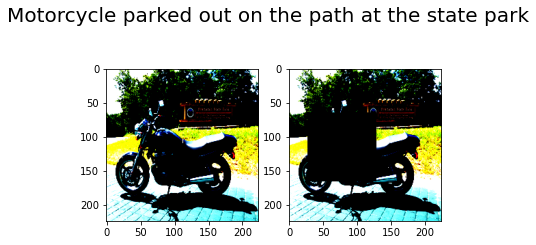

In [5]:
show_sample(dataset_train[0])

In [6]:
import torch
from torch import nn
class Generator(nn.Module):

    #generator model
    def __init__(self):
        super(Generator,self).__init__()
        
        self.t1=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU(0.2,inplace=True)
        )
        
        self.t2=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.t3=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.t4=nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.t5=nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True)
            
        )
#         self.t6=nn.Sequential(
#             nn.Conv2d(512,4000,kernel_size=(4,4)), #bottleneck
#             nn.BatchNorm2d(4000),
#             nn.ReLU()
#         )
        
        self.t7=nn.Sequential(
            nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.t8=nn.Sequential(
            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.t9=nn.Sequential(
            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.t10=nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.t11=nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=(4,4),stride=2,padding=1),
            nn.Tanh()
            )

    def forward(self,x):
        x=self.t1(x)
        x=self.t2(x)
        x=self.t3(x)
        x=self.t4(x)
        x=self.t5(x)
        #x=self.t6(x)
        x=self.t7(x)
        x=self.t8(x)
        x=self.t9(x)
        x=self.t10(x)
        x=self.t11(x)
        return x #output of generator

In [7]:
import torch
from torch import nn
class Discriminator(nn.Module):

    #discriminator model
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.t1=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU(0.2,inplace=True)
        )
        
        self.t2=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True)
        )
        
        self.t3=nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.t4=nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.t5=nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=1,kernel_size=(4,4),stride=1,padding=0),
            nn.Flatten(start_dim=1)
        )
        self.t6 = nn.Sequential(
            nn.Linear(121, 121),
            nn.Linear(121, 1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x=self.t1(x)
        x=self.t2(x)
        x=self.t3(x)
        x=self.t4(x)
        x=self.t5(x)
        x=self.t6(x)
        #print(x.size())
        return x #output of discriminator

In [9]:
n_epochs = 50 # number of epochs of training
batch_size = 64 # size of the batches
n_cpu = 8 # number of cpu threads to use during batch generation

# Adam parameters
lr = 0.0002 # adam: learning rate
b1 = 0.5 # adam: decay of first order momentum of gradient
b2 = 0.999 # adam: decay of first order momentum of gradient

#latent_dim = (3,1000,1000) # dimensionality of the latent space
img_size = 64 # size of each image dimension
channels = 3 # number of image channels
sample_interval = 500 # interval betwen image samples
img_shape = (channels, img_size, img_size)

In [ ]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()
adversarial_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------
for epoch in tqdm(range(n_epochs)):
    for i, batch in enumerate(trainloader):
        
        imgs = batch['masked_image'].cuda()
        
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        #real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        #z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0],) +  latent_dim)))
        #print(z.shape)

        # Generate a batch of images
        gen_imgs = generator(imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples

        if epoch % 2 == 0:
            real_loss = adversarial_loss(discriminator(imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss)

            d_loss.backward()
            optimizer_D.step()

        batches_done = epoch * len(trainloader) + i
        if batches_done % sample_interval == 0:
            print(str(datetime.now()), "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, i, len(trainloader), d_loss.item(), g_loss.item()) )
            #save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
    torch.save(generator.state_dict(), f"./GAN_generator_epoch_{epoch}_{str(g_loss.item())}.pth")
    torch.save(discriminator.state_dict(), f"./GAN_discriminator_epoch_{epoch}_{str(d_loss.item())}.pth")

2020-11-04 00:22:53.720370 [Epoch 0/50] [Batch 0/9242] [D loss: 1.387599] [G loss: 0.728564]
2020-11-04 00:25:30.142247 [Epoch 0/50] [Batch 500/9242] [D loss: 0.094264] [G loss: 4.763416]
2020-11-04 00:28:07.458734 [Epoch 0/50] [Batch 1000/9242] [D loss: 0.001279] [G loss: 7.066759]
2020-11-04 00:30:40.541582 [Epoch 0/50] [Batch 1500/9242] [D loss: 0.111465] [G loss: 3.718244]
2020-11-04 00:33:12.686981 [Epoch 0/50] [Batch 2000/9242] [D loss: 0.000504] [G loss: 8.382323]
2020-11-04 00:35:53.907564 [Epoch 0/50] [Batch 2500/9242] [D loss: 0.008397] [G loss: 9.185885]
2020-11-04 00:38:28.569104 [Epoch 0/50] [Batch 3000/9242] [D loss: 0.000163] [G loss: 8.743296]
2020-11-04 00:41:01.104389 [Epoch 0/50] [Batch 3500/9242] [D loss: 0.000091] [G loss: 9.378012]
2020-11-04 00:43:32.878895 [Epoch 0/50] [Batch 4000/9242] [D loss: 0.000047] [G loss: 10.007874]
2020-11-04 00:46:09.086344 [Epoch 0/50] [Batch 4500/9242] [D loss: 0.000019] [G loss: 10.950983]
2020-11-04 00:48:43.772183 [Epoch 0/50] [B

In [ ]:
with torch.no_grad():
    z = Variable(Tensor(np.random.normal(0, 1, (128, latent_dim))))
    gen_imgs = generator(z)